In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as pplt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from gtfparse import read_gtf

In [2]:
imp_vars = pd.read_excel('02_output_analysis/vars_facts_together.xlsx')
var_seq = pd.read_pickle('00_dataframes/cDNA_protSeq_first_vars')
#variants = pd.read_pickle('03_for_cDNA/vars_prot_ips')
#ips_dict = pickle.load(open('00_dataframes/ips_dict', 'rb'))
#all_vars = pd.read_pickle('00_dataframes/all_annotated_vars')

In [3]:
imp_vars = pd.merge(imp_vars, var_seq[['shortcut', 'protein_seq', 'termin_prot', 'ref_cDNA', 'ref_protein_seq']], 
                    left_on='shortcut_v', right_on='shortcut', how='left')

In [4]:
def search_col(df, inp):
    return [i for i in df.columns if inp.lower() in (i.lower())]

### InterProScan dictionary

In [4]:
#dom_eff = variants[(variants['domains_effected'].astype(str)!='[]')|(variants['domains_deleted'].astype(str)!='[]')
#                  ].copy().reset_index(drop=True)

In [ ]:
# for ips selection: 'where_data_from' --> ProSiteProfiles, MobiDBLite

### UniProt domains

In [5]:
# genes for UniProt ID
with open('03_for_cDNA/uniprot_ids.txt', 'w') as o:
    for i in sorted(set(imp_vars['HUGO_Symbol'])):
        o.write(i+'\n')

In [6]:
# IDs as df
exc_uniprot = pd.read_excel('03_for_cDNA/gene_id_uniprot.xlsx')
exc_uniprot = exc_uniprot.drop(columns=['Entry name', 'Status', 'Gene names', 'Organism'])
exc_uniprot = exc_uniprot.rename(columns={'yourlist:M20211028F248CABF64506F29A91F8037F07B67D1258226A':'HUGO_Symbol'})

/software/miniconda3/envs/Alexandra_DEV/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# gff format of UniProt outcome with domains
gff = pd.read_csv('03_for_cDNA/uniprot_proteins.gff', sep='\t', comment='#', 
                  names=['Entry', 'where_from', 'item', 'start_pos', 'end_pos', 'o0', 'o1', 'o2', 'ids', 'o3'], 
                  usecols=['Entry', 'item', 'start_pos', 'end_pos', 'ids'])
gff = gff[gff['item'].isin(['Domain', 'Nucleotide binding', 'Region', 'Active site', 'Binding site', 'Zinc finger',
                            'Site', 'Metal binding', 'Motif', 'Compositional bias', 'Signal peptide', 'Propeptide', 
                            'Topological domain', 'Transmembrane', 'DNA binding', 'Transit peptide', 
                            'Initiator methionine'])]

In [8]:
# merged gene name and domains
up_df = pd.merge(gff, exc_uniprot, on='Entry', how='right')
up_df = up_df.drop_duplicates()
up_df = up_df[up_df['start_pos'].notnull()]
up_df[['start_pos', 'end_pos', 'Length']] = up_df[['start_pos', 'end_pos', 'Length']].astype(int)
up_df['info_domain'] = up_df['ids'].str.split('=', expand=True)[1].str.split(';', expand=True)[0]
up_df = up_df[['HUGO_Symbol', 'Entry', 'start_pos', 'end_pos', 'item', 'info_domain', 'Length', 'Protein names', 
               'ids']]
up_df = up_df.sort_values(by=['HUGO_Symbol', 'start_pos', 'end_pos']).reset_index(drop=True)

In [130]:
#up_df.to_pickle('00_dataframes/uniprot_domains')

In [10]:
#pd.read_pickle('00_dataframes/uniprot_domains').to_excel('02_output_analysis/domains_uniprot.xlsx')

### Protein domain analysis

In [9]:
up_df = pd.read_pickle('00_dataframes/uniprot_domains')

### NMD line

In [10]:
# GTF file with sequence information
gtf_df = read_gtf('/mnt/g27prist/CMTD/Stephan/bcbio_installation/genomes/Hsapiens/GRCh37/StephanDatabase/GRCH37'+
                  '/annotation/GRCh37_latest_genomic_replace.gtf')
# only those reference transcripts within variant file
gtf_df['transcript_id'] = gtf_df['transcript_id'].str.split('.',expand=True)[0]
gtf_df = gtf_df[gtf_df['transcript_id'].isin(set(imp_vars['RefSeq accession']))]
gtf_df = gtf_df[gtf_df['feature']=='CDS']
gtf_df = gtf_df[gtf_df['seqname']!='NW_003871056.3']
gtf_df['exon_number'] = gtf_df['exon_number'].astype(int)

INFO:root:Extracted GTF attributes: ['gene_id', 'db_xref', 'description', 'gbkey', 'gene', 'gene_biotype', 'pseudo', 'transcript_id', 'product', 'exon_number', 'gene_synonym', 'tag', 'protein_id', 'exception', 'inference', 'note', 'partial', 'The', 'transl_except', 'isoform', 'anticodon', 'non-AUG', 'standard_name', 'source', 'similar', 'transferase', 'codons', '12S', '16S', 'transl_table', 'ATPase']


In [12]:
def nmd_pos(gene):
    gtf_spec = gtf_df[gtf_df['gene']==gene]
    nmd_exon = max(gtf_spec['exon_number'].unique())-1
    len_exon = (int(gtf_spec['end'][gtf_spec['exon_number']==nmd_exon])-
                int(gtf_spec['start'][gtf_spec['exon_number']==nmd_exon]))
    strand = gtf_spec['strand'].unique()[0]
    len_cdna = 0

    for i in gtf_spec['exon_number'].unique():
        if i < nmd_exon:
            len_cdna += (int(gtf_spec['end'][gtf_spec['exon_number']==i])-
                         int(gtf_spec['start'][gtf_spec['exon_number']==i]))

    if len_exon > 50:
        if strand=='+':
            nmd_pos = int(gtf_spec['end'][gtf_df['exon_number']==nmd_exon])-50
            len_cdna += (nmd_pos-int(gtf_spec['start'][gtf_df['exon_number']==nmd_exon]))
        else:
            nmd_pos = int(gtf_spec['start'][gtf_df['exon_number']==nmd_exon])+50
            len_cdna += (int(gtf_spec['end'][gtf_df['exon_number']==nmd_exon])-nmd_pos)

    return (len_cdna, round(len_cdna/3))

In [13]:
nmd_lst = []
for g in imp_vars['HUGO_Symbol'].unique():
    c,p = nmd_pos(g)
    nmd_lst.append([g,c,p])

nmd_df = pd.DataFrame(nmd_lst, columns=['gene', 'NMD_cDNA', 'NMD_protein'])

In [14]:
nmd_df.to_pickle('00_dataframes/nmd_df')

In [15]:
nmd_df = pd.read_pickle('00_dataframes/nmd_df')

### Visualization Exons

In [19]:
def prot_domains(ind, df_var, up_df):
    if ind in df_var.index:
        prot = df_var.iloc[ind]['HUGO_Symbol']
        ips_prot = up_df[up_df['HUGO_Symbol']==prot]
        shortcut = df_var.iloc[ind]['shortcut_v']
        
        nmd_pos = int(nmd_df['NMD_protein'][nmd_df['gene']==prot])

        prot_change_pos = df_var.iloc[ind]['prot_change_pos']
        aa_next_pos = df_var.iloc[ind]['aa_next_pos']
        termin_pos = df_var.iloc[ind]['ter_p_len']

        max_pos = df_var.iloc[ind]['ref_p_len']

        seq_alt = df_var.iloc[ind]['protein_seq']
        seq_ref = df_var.iloc[ind]['ref_protein_seq']
    
        if type(prot_change_pos)==int:
            try:
                seq_alt = seq_alt[prot_change_pos-10:prot_change_pos+9]
                seq_ref = seq_ref[prot_change_pos-10:prot_change_pos+9]
            except:
                seq_alt = seq_alt[prot_change_pos-10:]
                seq_ref = seq_ref[prot_change_pos-10:]
            seq_match = ''
            for a,r in zip(seq_alt, seq_ref):
                if a==r:
                    seq_match += '|'
                else:
                    seq_match += ' '

            inds = ips_prot.index
            starts = ips_prot['start_pos']
            ends = ips_prot['end_pos']
            ids = ips_prot['info_domain']
            ys = np.arange(0.01,1,1/len(ips_prot))

            fig = plt.subplots(figsize=(14, 6))
            ax1 = plt.subplot(1,1,1)

            plt.ylim([0,1])
            plt.xlim([0,max_pos])
            ax1.get_yaxis().set_visible(False)
            ax1.set_xlabel('amino acid position', fontsize=12)
            ax1.xaxis.set_label_coords(0.5, -0.1)

            ax1.set_title('Protein domains of %s (%s)' %(prot, shortcut), fontsize = 18, fontweight = 'bold', 
                          loc = 'center')

            for i,s,e,y,t in zip(inds, starts, ends, ys, ids):
                ax1.add_patch(pplt.Rectangle((s, y), e-s, 0.01, fc = 'black', ec = 'black', alpha = 1))
                plt.text(max_pos+5, y, t, size = 13, ha='left')
            if prot_change_pos != 'no_change':
                ax1.add_patch(pplt.Rectangle((prot_change_pos, 0), 0.01, 1, fc = 'green', ec = 'green', alpha = 1))
                plt.text(x=prot_change_pos, y=-0.10, s='aa substitution', ha='center', c='green')
                if aa_next_pos not in ['probably frameshift', 'error']:
                    ax1.add_patch(pplt.Rectangle((prot_change_pos, 0), aa_next_pos-prot_change_pos, 1, 
                                                 fc = 'green', ec = 'green', alpha = 0.5))
                elif aa_next_pos == 'probably frameshift':
                    ax1.add_patch(pplt.Rectangle((prot_change_pos, 0), termin_pos-prot_change_pos, 1, 
                                                 fc = 'magenta', ec = 'magenta', alpha = 0.5))
            if aa_next_pos not in ['probably frameshift', 'error']:
                ax1.add_patch(pplt.Rectangle((termin_pos+(aa_next_pos-prot_change_pos), 0), 0.01, 1, fc = 'red', 
                                             ec = 'red', alpha = 1))
                plt.text(x=termin_pos+(aa_next_pos-prot_change_pos), y=-0.07, s='stop', ha='center', c='red')
            elif aa_next_pos == 'probably frameshift':
                ax1.add_patch(pplt.Rectangle((termin_pos, 0), 0.01, 1, fc = 'red', ec = 'red', alpha = 1))
                plt.text(x=termin_pos, y=-0.07, s='stop', ha='center', c='red')
            
            ax1.add_patch(pplt.Rectangle((nmd_pos, 0), 0.01, 1, fc = 'blue', ec = 'blue', alpha = 1))
            plt.text(x=nmd_pos, y=-0.13, s='NMD', ha='center', c='blue')
            plt.text(x=1, y=0.9, s=seq_alt, size = 15, ha='left', family='monospace')
            plt.text(x=1, y=0.85, s=seq_match, size = 15, ha='left', family='monospace')
            plt.text(x=1, y=0.8, s=seq_ref, size = 15, ha='left', family='monospace')
            plt.gcf().subplots_adjust(bottom = 0.12, top = 0.94, left = 0.01, right = 0.6)
            plt.savefig('02_output_analysis/00_domain_figs/dom_%s.png'%shortcut)
        else:
            print('no change in protein sequence')
    else:
        print('index not in dataframe')

In [91]:
imp_vars[imp_vars['HUGO_Symbol']=='SUFU']

,#CHROM,POS,REF,ALT,MaxEntScan_alt,MaxEntScan_diff,MaxEntScan_ref,CADD_PHRED,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,...,own_ACMG_class,qci_disease,cancer_types,ID_Person,KGE_HBOC,shortcut_y,protein_seq,termin_prot,ref_cDNA,ref_protein_seq
25,10,104389820,C,A,7.241,3.259,10.5,23.8,19,3,...,pathogenic,Basal cell nevus syndrome,"pleural cancer, skin cancer, stomach cancer, c...",NaN,NaN,10_104389820_C_A_0,MAELRPSGAPGPTAPPAPGPTAPPAFASLFPPGLHAIYGECRRLYP...,MAELRPSGAPGPTAPPAPGPTAPPAFASLFPPGLHAIYGECRRLYP...,ATGGCGGAGCTGCGGCCTAGCGGCGCCCCCGGCCCCACCGCGCCCC...,MAELRPSGAPGPTAPPAPGPTAPPAFASLFPPGLHAIYGECRRLYP...


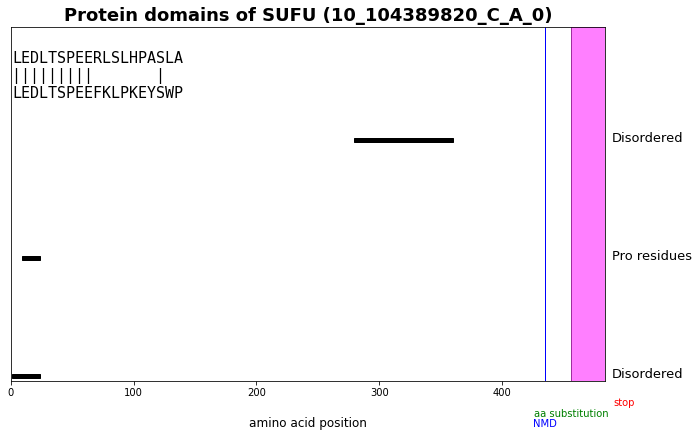

In [92]:
prot_domains(25, imp_vars, up_df)